In [ ]:
!pip install ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, FloatSlider, interactive
from IPython.display import display
import plotly.graph_objects as go
%matplotlib ipympl

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

# Demystifying LayerNorm

# Table of Contents
- [Chapter 0: Definition](#chapter-0)
- [Chapter 1: Compose LayerNorm into familiar transformations](#chapter-1)
- [Chapter 2: Loss of Dimension due to  $𝑍(𝑥⃗)$](#chapter-2)
- [Chapter 3: $𝑍(𝑥⃗)$ vs Normalisation](#chapter-3)
- [Chapter 4: Visualise effect of  $𝑁(𝑥⃗)$ ](#chapter-4)
- [Chapter 5: Affine Transformation](#chapter-5)
- [Chapter 6: LayerNorm vs RMSNorm](#chapter-6)

---

# Chapter 0: Definition
<a name="chapter-0"></a>
Normalisation is an overloaded term with varies with contexts. Therefore, I will take this opportunity to state definitions useful to layernorm.
> **Note:** The following definitions will be revisited with a geometric interpretation so do not ponder over these for too long. Rather, use them as a reference for building intuition later.


**Normalisation**: This is the process of transforming a vector into a unit vector by scaling. Let $\vec{x} \in \mathbb{X}^n$. Then, the normalisation transformation $T$ produces the unit vector $\hat{x}$ as follows:
\begin{aligned}
\hat{x} &= T\vec{x} = \frac{\vec{x}}{\| \vec{x} \|} \\
\| \hat{x} \| &= \left\| \frac{\vec{x}}{\| \vec{x} \|} \right\| = \frac{\| \vec{x} \|}{\| \vec{x} \|} = 1
\end{aligned}

**LayerNorm** Unfortunately, LayerNorm is not the linear transformation seen above. Using the same $\vec{x}$ from before,
\begin{aligned}
\text{LayerNorm}(\vec{x}) &= \vec{y} = \frac{\vec{x} - \vec{\mu}}{\sqrt{\sigma^2 + \epsilon}} * \vec{\gamma} + \vec{\beta} , \quad \epsilon > 0, \ \vec{\gamma} \in \mathbb{R^n}, \ \vec{\beta} \in \mathbb{X}^n \\
\mu &:= \frac{1}{n}\sum_{i=1}^{n} x_i, \quad \vec{\mu} = (\mu, \mu, \ ... \ , \ \mu)^T \\
\sigma^2 &:= \frac{1}{n}\sum_{i=1}^{n} (x_i - \mu_i)^2
\end{aligned}
\* is element wise multiplication.

By weak law of large numbers, $\mu$ and $\sigma^2$ are approximates for the mean $\mathbb{E}[X]$ and variance Var($X$) if $\vec{x}$ is treated as a random sequence $(X_1, X_2, ..., X_n)$ where $X_i$ are i.i.d. Therefore, an alternate definition is seen in [tensorflow documentation](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html) for layer norm:

\begin{aligned}
y = \frac{\vec{x} - \mathbb{E}[X]}{\sqrt{\text{Var}(X) + \epsilon}} * \vec{\gamma} + \vec{\beta}
\end{aligned}
In the above formula, Addtion and Subtraction are broadcasted (expanded into vectors of equal dimensions)

> **Caveats:**
1. Should the individual neurons in a layer have the same distribution or same mean and variance as assumed?
2. Should the neurons in a layer be independant as assumed?

---

# Chapter 1: Compose LayerNorm into familiar transformations
<a name="chapter-1"></a>
The layernorm transformation is a composition of 2 simpler transformations.
\begin{aligned}
Z(\vec{x}) &= \frac{\vec{x} - \vec{\mu}}{\sqrt{\sigma^2 + \epsilon}} \\
A(\vec{x}) &= \vec{x} * \vec{\gamma} + \vec{\beta} \\
\text{LayerNorm}(\vec{x}) &= (A ∘ Z) \ (\vec{x})
\end{aligned}

Going in the order of function composition, let us study $Z$ first. We have seen $Z$ before, it is the z-score standardization (almost, due to an additional $\epsilon$ introduced).

**z-score standardisation** (in 1-D) \\
Let $X$ be a random variable that is normally distributed as $X \sim \mathbb{N}(\mu, \sigma^2)$. The z-score, $Z = \frac{X-\mu}{\sigma}$, is a convient variable transformation that meets the following properties:

1. $Z \sim \mathbb{N}(0, 1)$ \\
Proof: \\
$
\mathbb{E}[Z] = \mathbb{E}\left[\frac{X-\mu}{\sigma}\right] = \frac{\mathbb{E}[X]-\mu}{\sigma} = \frac{\mu-\mu}{\sigma} = 0
$ \\
$
\text{Var}(Z) = \text{Var}\left(\frac{X-\mu}{\sigma}\right) = \text{Var}\left(\frac{X}{\sigma}\right) - \text{Var}\left(\frac{\mu}{\sigma}\right) = \text{Var}\left(\frac{X}{\sigma}\right) = \frac{1}{\sigma^2}\text{Var}(X) = 1
$

2. $\mathbb{P}(X <= x) = \mathbb{P}\left(Z <= \frac{x-\mu}{\sigma}\right)$ \\
Proof comes from the normal distribution formula.

> **Note:** $\epsilon$ handles the situations when $\sigma$ is arbitrarily small. The effect of $\epsilon$ will be studied later.

Here are 2 distributions that, under z-score standardization, get transformed into distributions with mean 0 and variance 1.

In [ ]:
def plot_z_score_standardization(mean, std, nbins, ax, rv, title, x_label, z_label):

    x = rv
    z = (x - mean) / std

    xy_hist, x_hist = np.histogram(x, bins = nbins, density = True)
    zy_hist, z_hist = np.histogram(z, bins = nbins, density = True)

    x_hist = x_hist[1:]
    z_hist = z_hist[1:]

    ax.plot(x_hist, xy_hist, label=x_label)
    ax.plot(z_hist, zy_hist, label=z_label)
    ax.grid()
    ax.legend(fontsize=12)
    ax.set_title(title)

    x_calculated_mean = np.mean(x)
    x_calculated_var = np.var(x)

    z_calculated_mean = np.mean(z)
    z_calculated_var = np.var(z)

    print(f"X Mean {x_calculated_mean:.2f}")
    print(f"X Var {x_calculated_var:.2f}")
    print(f"Z Mean {z_calculated_mean:.2f}")
    print(f"Z Var {z_calculated_var:.2f}")
    print()

X Mean 10.03
X Var 15.97
Z Mean 0.01
Z Var 1.00

X Mean 9.99
X Var 15.95
Z Mean -0.00
Z Var 1.00



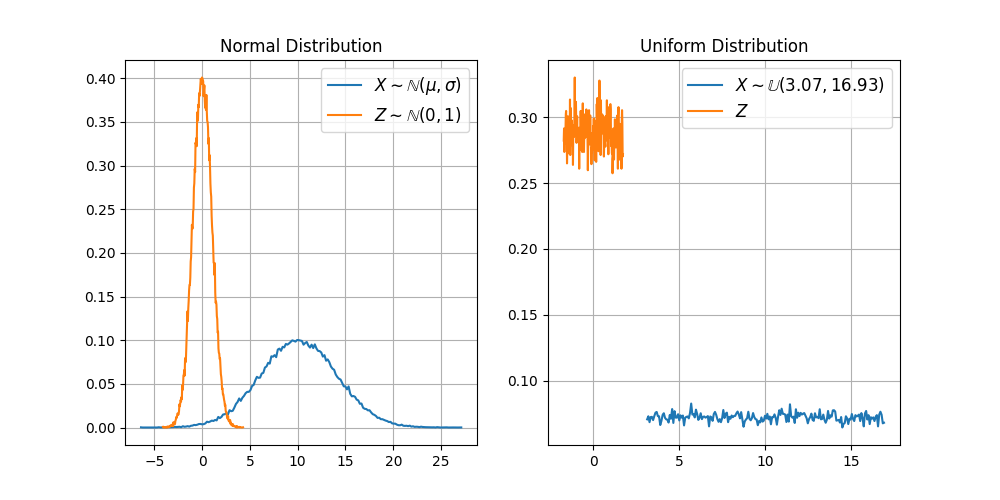

In [ ]:
mean = 10; std = 4; N = 100000; nbins = 200
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))

x_normal = np.random.normal(loc = mean, scale = std, size = N)
x_uniform = np.random.uniform(low = mean - (3**0.5)*std, high = mean + (3**0.5)*std, size = N)

plot_z_score_standardization(mean, std, nbins, ax[0], x_normal, "Normal Distribution", "$X \sim \mathbb{N}(\mu, \sigma)$", "$Z \sim \mathbb{N}(0, 1)$")
plot_z_score_standardization(mean, std, nbins, ax[1], x_uniform, "Uniform Distribution", "$X \sim \mathbb{U}(3.07, 16.93)$", "$Z $")

plt.show()

# Chapter 2: Loss of Dimension due to $Z(\vec{x})$
<a name="chapter-2"></a>

However, $Z(\vec{x})$ is not an operation on a random variable but rather a vector. However, the idea of making the mean 0 and variance 1 carries over.

Consider the vector $\vec{p} = \vec{x} - \vec{\mu} = (x_1 - \mu, \ x_2 - \mu, \ ... \ , x_n - \mu )^T$. \\
All possible $\vec{p}$ belong to the plane perpendicular to $\vec{\mu} = \mu (1,1,...,1)^T = \mu \textbf{1}$ \\
Proof: \\
$\vec{p} \cdot \textbf{1} = \sum_{i = 0}^n (x_i - \mu) = \sum_{i = 0}^n x_i - \sum_{i = 0}^n \mu = n\mu - n\mu = 0$

This plane goes through the origin as $\vec{x} = \mu \Rightarrow \vec{p} = 0$

Below, vectors are generated from different distributions (each coordinate is i.i.d) but the planes formed by $\vec{p}$ is still perpendicular to (1,1,1)


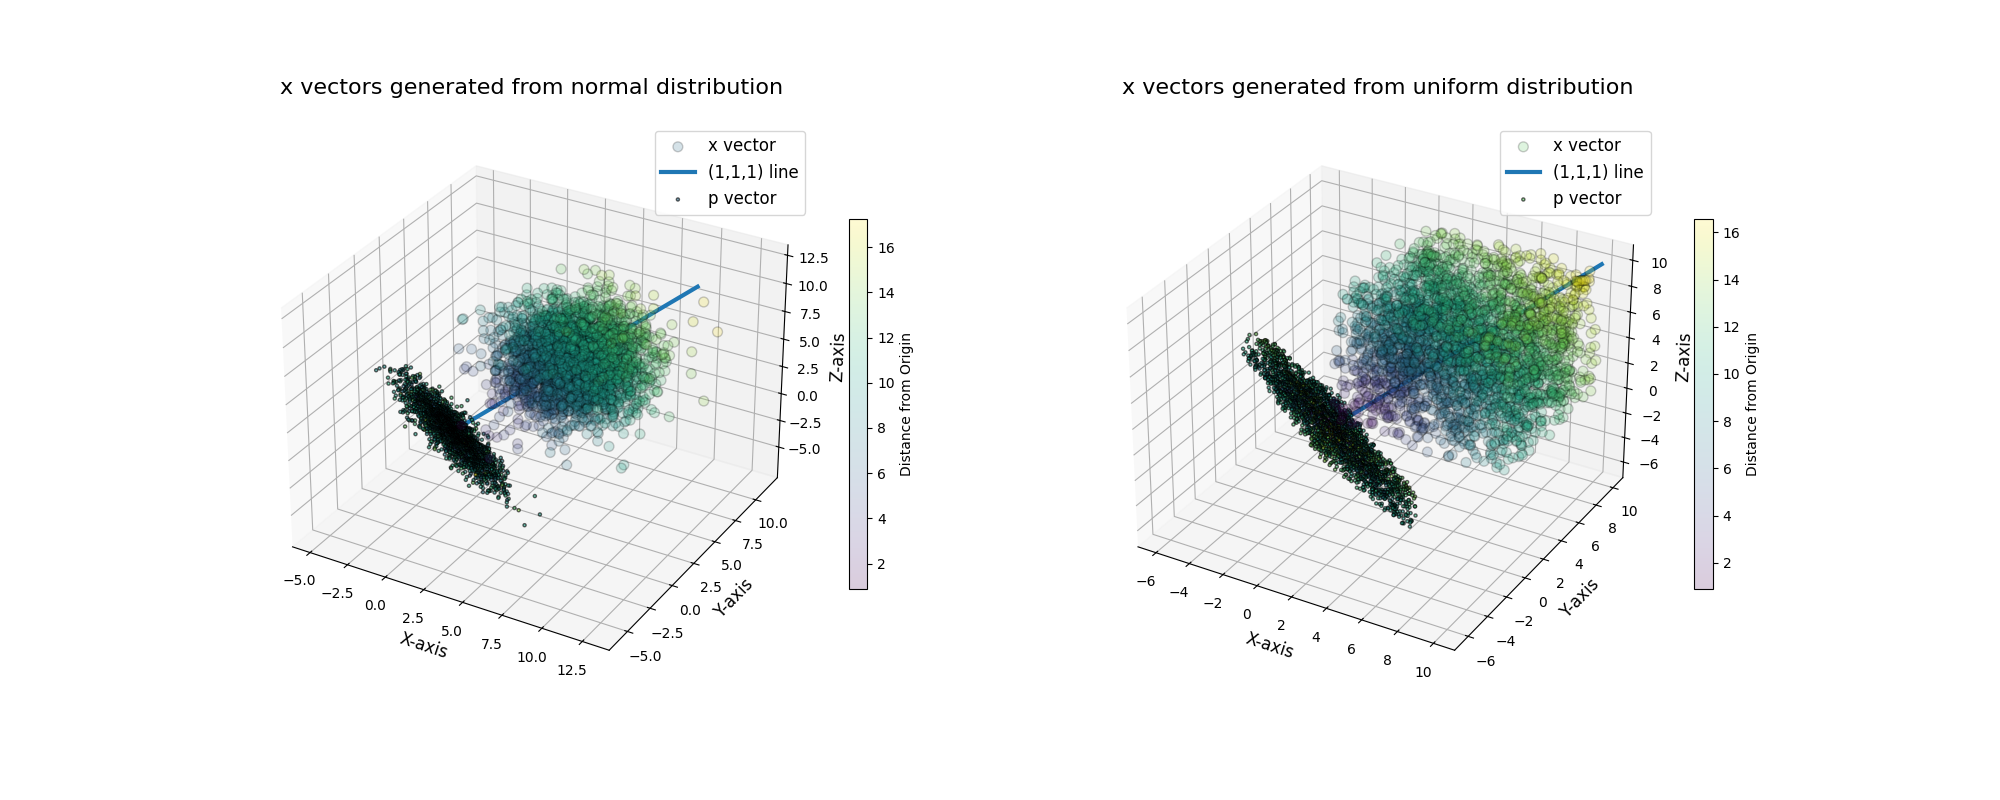

In [ ]:
def plot_3d_scatter(ax, x, y, z, title):
    colors = np.sqrt(x**2 + y**2 + z**2)  # Color based on distance from origin

    # Scatter plot
    scatter = ax.scatter(x, y, z, c=colors, s=50, cmap='viridis', alpha=0.2, edgecolor='k', label = 'x vector')

    # Add color bar
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.6)
    cbar.set_label('Distance from Origin')

    ax.plot([0,10], [0,10], [0,10], label='(1,1,1) line',linewidth=3.0)

    # plane plot
    mu = (x + y + z)/3

    scatter2 = ax.scatter(x-mu, y-mu, z-mu, s=5, alpha=0.6, c=colors, cmap='viridis', edgecolor='k', label = 'p vector')

    # Customize the plot
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xlabel('X-axis', fontsize=12)
    ax.set_ylabel('Y-axis', fontsize=12)
    ax.set_zlabel('Z-axis', fontsize=12)
    ax.grid(True)
    ax.legend(fontsize=12)

# Generate random data
np.random.seed(42)  # For reproducibility
num_points = 3000
x_normal = np.random.normal(loc = 5, scale = 2, size = num_points)
y_normal = np.random.normal(loc = 5, scale = 2, size = num_points)
z_normal = np.random.normal(loc = 5, scale = 2, size = num_points)

x_uniform = np.random.uniform(low = 0, high = 10, size = num_points)
y_uniform = np.random.uniform(low = 0, high = 10, size = num_points)
z_uniform = np.random.uniform(low = 0, high = 10, size = num_points)


# Create 3D scatter plot
fig = plt.figure(figsize=(20, 8))
ax0 = fig.add_subplot(1,2,1, projection='3d')

plot_3d_scatter(ax0, x_normal, y_normal, z_normal, 'x vectors generated from normal distribution')

# Create 3D scatter plot
ax1 = fig.add_subplot(1,2,2, projection='3d')
plot_3d_scatter(ax1, x_uniform, y_uniform, z_uniform, 'x vectors generated from uniform distribution')

plt.show()



The dimensionality of the vector space spanned by $\vec{x}$ therefore gets reduced by 1 when transformed into $\vec{p}$. This transformation supresses activations of the form $x_1 = x_2 = ... = x_n$. In LLM context, this apprears to be a useless activation that could lead to positive feedback later on. However, that is debatable.

# Chapter 3: $Z(\vec{x})$ vs Normalisation
<a name="chapter-3"></a>
Let's look back at $Z(\vec{x})$.

\begin{aligned}
    Z(\vec{x}) &= \frac{\vec{x} - \vec{\mu}}{\sqrt{\sigma^2 + \epsilon}} \\
    &= \frac{\vec{p}}{\sqrt{\left(\frac{1}{n}\sum_{i=1}^{n} (x_i - \mu_i)^2 \right) + \epsilon}} \\
    &= \frac{\vec{p}}{\sqrt{\left(\frac{1}{n}\sum_{i=1}^{n} p_i^2 \right) + \epsilon}} \\
    &= \frac{\vec{p}}{\sqrt{\frac{1}{n}\|\vec{p}\|^2 + \epsilon}} \quad \text{(variance coincides with magnitude)}\\
    &= \sqrt{n}\frac{\vec{p}}{\sqrt{\|\vec{p}\|^2 + n\epsilon}} \\
    &= \sqrt{n} N(\vec{p})
\end{aligned}

The final step is the normalisation of $\vec{p}$ that we saw in Chapter 0 (and some $\epsilon$ action).

$Z(\vec{x})$ can therefore be composed into 2 transformations, $\sqrt{n} \ (N \circ M) \ (\vec{x})$ where $M(\vec{x}) = \vec{x} - \vec{\mu}$. \\

The normalisation step is not surprising as we saw previously that z-score standardisation reduces mean to 0 and variance to 1. Due to removing the mean, the the final vector will have 0 mean. The expression for variance will also coincide with the magnitude of the vector, which is 1 (a unit vector after normalisation).  

$N(\vec{p})$ introduces non-linearity into LayerNorm. Therfore, we should spend some time studying how $\vec{z} = N(\vec{p})$ changes with $\vec{p}$.



> **Note**: For small $\epsilon$, $\vec{z}$ will lie approximately on the unit circle. As $\epsilon$ increases, the final vectors "shrink" into the circle.

# Chapter 4: Visualise effect of $N(\vec{x})$
<a name="chapter-4"></a>

Consider a general 2d vector $\vec{v} = (x,y)$. Before the LayerNorm, there will likely be a neural network. Therefore, it is meaningful to look at how $\vec{v_{\text{after}}} = W\vec{v_{\text{before}}} + \vec{bias}$ affects $N(\vec{v})$. This is an affine transformation. \\

In 2d, the plots below depict how $ N\left((sx + a, ty + b)^T\right)$ changes with scaling factors s,t and bias a,b.

In [ ]:
# Define the transformation function
def transform_points(s, t, x, y, a, b, e):

    denominator = np.sqrt((s * x + a)**2 + (t * y + b)**2 + e)
    # Avoid division by zero
    denominator[denominator == 0] = np.nan
    # mu = ((s * x + a) + (t * y + b)) / 2
    # return (s * x + a - mu) / denominator, (t * y + b - mu) / denominator
    return (s * x + a) / denominator, (t * y + b) / denominator

# Function to update the plot
def update_plot(s=1.0, t=1.0, a= 0.0, b = 0.0, e = 0.0):
    # Generate a grid of points
    x = np.linspace(-10, 10, 10)
    y = np.linspace(-10, 10, 10)

    X, Y = np.meshgrid(x, y)

    # Transform the points
    X_transformed, Y_transformed = transform_points(s, t, X, Y, a, b, e)

    # Flatten the arrays for scatter plot
    X_flat = X_transformed.flatten()
    Y_flat = Y_transformed.flatten()
    Original_X_flat = X.flatten()

    # Map original x to colors: blue for positive, red for negative
    colors = np.interp(Original_X_flat, (Original_X_flat.min(), Original_X_flat.max()), (0, 1))

    # Create the plot
    fig = go.Figure(data=go.Scatter(
        x=X_flat,
        y=Y_flat,
        mode='markers',
        marker=dict(size=8, color=colors, colorscale='RdBu', opacity=0.8),
        name="final vectors"
    ))

    # Plot the unit circle
    theta = np.linspace(0, 2 * np.pi, 100)
    x_unit = np.cos(theta)
    y_unit = np.sin(theta)

    fig.add_trace(go.Scatter(
        x=x_unit,
        y=y_unit,
        mode='lines',
        line=dict(color='black', width=1),
        name='Unit Circle'
    ))

    # Customize the layout
    fig.update_layout(
        title=f"2D Scatter Plot with s={s:.2f}, t={t:.2f}, a={a:.2f}, b={b:.2f}, e={e:.2f}",
        xaxis_title="$z_x$",
        yaxis_title="$z_y$",
        xaxis=dict(
            showgrid=True,
            zeroline=True,
            scaleanchor="y",  # Fix aspect ratio
            range=[-1.5, 1.5]  # Fixed x-axis range to fit unit circle
        ),
        yaxis=dict(
            showgrid=True,
            zeroline=True,
            scaleanchor="x",  # Fix aspect ratio
            range=[-1.5, 1.5]  # Fixed y-axis range to fit unit circle
        ),
        width=800,
        height=800,
    )

    fig.show()

# Create interactive sliders
s_slider = (0.1, 10.0, 0.1)
t_slider = (0.1, 10.0, 0.1)

a_slider = (-20, 20, 0.1)
b_slider = (-20, 20, 0.1)

e_slider = (0, 20, 0.01)

interactive_plot = interactive(update_plot, s=s_slider, t=t_slider, a=a_slider, b=b_slider, e=e_slider)
display(interactive_plot)


interactive(children=(FloatSlider(value=1.0, description='s', max=10.0, min=0.1), FloatSlider(value=1.0, descr…

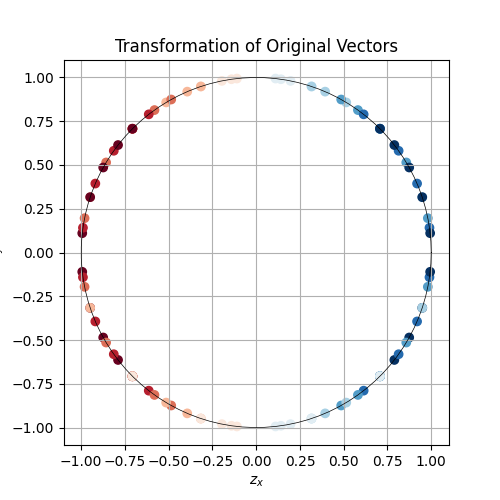

In [ ]:
from matplotlib import cm

def plot_final_vectors(ax, s, t, a, b, e):
    x = np.linspace(-10, 10, 10)
    y = np.linspace(-10, 10, 10)
    X, Y = np.meshgrid(x, y)

    # Transform the points
    x_transformed, y_transformed = transform_points(s, t, X, Y, a, b, e)

    # Flatten the arrays for scatter plot
    X_flat = x_transformed.flatten()
    Y_flat = y_transformed.flatten()
    Original_X_flat = X.flatten()

    # Normalize original x to map to color
    norm = plt.Normalize(Original_X_flat.min(), Original_X_flat.max())
    colors = cm.RdBu(norm(Original_X_flat))  # Get color values using RdBu colormap

    ax.scatter(x_transformed, y_transformed, c=colors)
    ax.grid()
    # ax.legend(fontsize=12)
    # Define the circle's parameters
    radius = 1
    center = (0, 0)

    # Create an array of angles from 0 to 2*pi
    theta = np.linspace(0, 2 * np.pi, 100)

    # Parametric equations for a circle
    x = center[0] + radius * np.cos(theta)
    y = center[1] + radius * np.sin(theta)

    # Plot the circle
    ax.plot(x, y, color='black', linewidth=0.5)

    # Set equal scaling and title
    ax.set_aspect('equal', 'box')


fig3, ax3 = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
plot_final_vectors(ax3, s=1, t=1, a=0, b=0, e=0)
ax3.set_title("Transformation of Original Vectors")
ax3.set_xlabel("$z_x$")
ax3.set_ylabel("$z_y$")

plt.show()


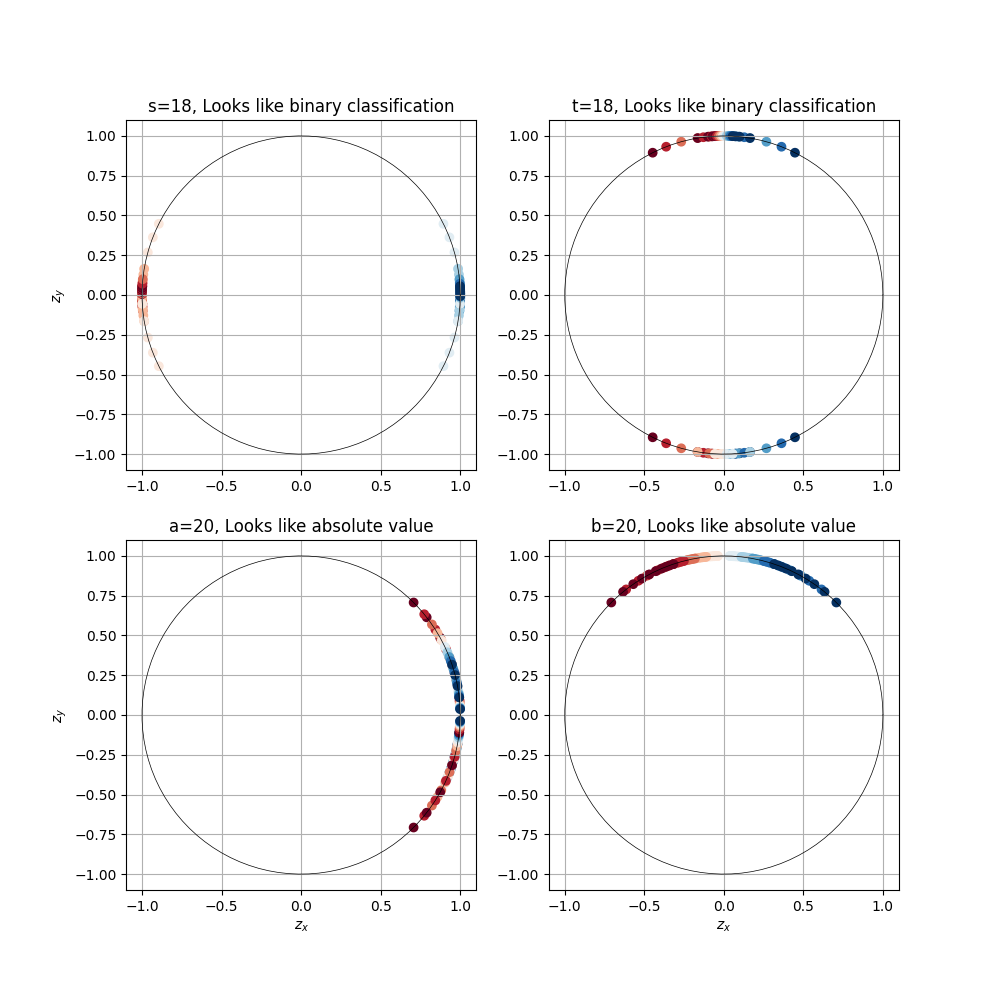

In [ ]:
fig4, ax4 = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_final_vectors(ax4[0][0], s=18, t=1, a=0, b=0, e=0)
ax4[0][0].set_title(f"s=18, Looks like binary classification")
ax4[0][0].set_ylabel("$z_y$")


plot_final_vectors(ax4[0][1], s=1, t=18, a=0, b=0, e=0)
ax4[0][1].set_title(f"t=18, Looks like binary classification")


plot_final_vectors(ax4[1][0], s=1, t=1, a=20, b=0, e=0)
ax4[1][0].set_title(f"a=20, Looks like absolute value")
ax4[1][0].set_xlabel("$z_x$")
ax4[1][0].set_ylabel("$z_y$")

plot_final_vectors(ax4[1][1], s=1, t=1, a=0, b=20, e=0)
ax4[1][1].set_title(f"b=20, Looks like absolute value")
ax4[1][1].set_xlabel("$z_x$")


plt.show()

The above plots visually shows how $N(\vec{v})$ can perform binary classification and take the absolute value of a certain axis. Here is a proof for those who are not convinced. Take the limit $\epsilon \rightarrow 0$.

1. Binary classification \\
Let $\vec{v} = (x,y)^T$. Then $\vec{v_s} = (sx,y)^T$ \\

\begin{aligned}
    \vec{z_s} &= N(\vec{v_s}) \rightarrow \left(\frac{sx}{\sqrt{s^2x^2 + y^2}}, \frac{y}{\sqrt{s^2x^2 + y^2}}\right) ^T \\
    \lim_{s\rightarrow\infty} \vec{z_s} &= \left(\lim_{s\rightarrow\infty} \frac{sx}{|sx|}, 0\right)^T = (\text{sign }(x), 0)^T \quad \text{(Binary classification)}
\end{aligned}

2. scaled down Absolute value of 1 axis \\
Let $\vec{v} = (x,y)^T$. Then $\vec{v_a} = (x+a,y)^T$ \\

\begin{aligned}
    \vec{z_a} &= N(\vec{v_a}) \rightarrow \left(\frac{x+a}{\sqrt{(x+a)^2 + y^2}}, \frac{y}{\sqrt{(x+a)^2 + y^2}}\right) ^T \\
    \lim_{a\rightarrow\infty} \vec{z_a} &= \left(\lim_{a\rightarrow\infty} \frac{a}{|a|}, 0\right)^T = (\text{sign }(a), 0)^T \quad \text{(new x > 0 if a > 0)}
\end{aligned}



# Chapter 5: Affine Transformation
<a name="chapter-5"></a>

The final transofrmation, $A(\vec{x}) = \vec{x} * \gamma + \vec{\beta}$, is an affine transformation. This is because the element wise multiplication with $\gamma$ can be rewritten as a matrix multiplication:

$$
A(\vec{x}) = \begin{bmatrix}
    \gamma_{1} & & \\
    & \ddots & \\
    & & \gamma_{n}
  \end{bmatrix} \vec{x} + \vec{\beta}
$$


# Chapter 6: LayerNorm vs RMSNorm
<a name="chapter-6"></a>
From [pytorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.modules.normalization.RMSNorm.html),

\begin{aligned}
    \text{RMSNorm}(x) &= \frac{\vec{x}}{\sqrt{\text{RMS}(\vec{x}) + \epsilon}} * \vec{\gamma} \quad \text{(WRONG)}
\end{aligned}

This is wrong. The original [Root Mean Square Layer Normalisation](https://arxiv.org/pdf/1910.07467) paper uses the following formula

\begin{aligned}
    \text{RMSNorm}(x) &= \frac{\vec{x}}{\sqrt{\text{MS}(\vec{x}) + \epsilon}} * \vec{\gamma} + \vec{\beta}\\
    &= \frac{\vec{x}}{\sqrt{\frac{1}{n}\|\vec{x}\|^2 + \epsilon}} * \vec{\gamma} + \vec{\beta} \\
    &= \sqrt{n} \ (A \circ N) \ (\vec{x})
\end{aligned}

This is very similar to $\text{LayerNorm} (\vec{x}) = \sqrt{n} \ (A \circ N \circ M) \ (\vec{x})$, with 2 differences.
1. There is no $M(\vec{x}) = \vec{x} - \vec{\mu}$. This is the step that removes the mean from the input vector, also known as centering about $\vec{0}$.

2. The input vector into $N$ is no longer a 0 mean vector $\vec{p}$ but instead an arbitrary vector. This however, does not change the analysis we did before for $N$ as we generalised to a general vector.

So what do these differences imply if the non-linearity concllusions of $N$ still apply? **computation speed**. These is no longer a need to perform centering that can be costly for long vectors.

This kind of contradicts what we stated earlier about LayerNorm supressing vectors parallel to $(1,1,...,1)^T$ being an effective way to get rid of "useless activations" and positive feedback. Turns out the main contribution to a low loss comes from the normalisation step $N$ as opposed to $M$ so removing $M$ does not harm the model.  



